In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from scipy.stats import zscore
from sklearn.preprocessing import minmax_scale

In [3]:
file_path = 'stats/remind_SSP2-PkBudg1150-SPS1_2030.xlsx'
sheet_name_gsa = 'GSA Delta'
sheet_name_mapping = 'Indices mapping'

# Load the "GSA delta" and "Indices mapping" sheets
df_gsa = pd.read_excel(file_path, sheet_name=sheet_name_gsa)
df_mapping = pd.read_excel(file_path, sheet_name=sheet_name_mapping)

In [4]:
product_mapping_dict = df_mapping.set_index('Value')['Product'].to_dict()
name_mapping_dict = df_mapping.set_index('Value')['Name'].to_dict()

lcia_method_mapping = {
    'EF v3.1 EN15804 - climate change - global warming potential (GWP100)': 'Global Warming Potential',
    'EF v3.1 EN15804 - ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe)': 'Ecotoxicity: freshwater',
    'Crustal Scarcity Indicator 2020 - material resources: metals/minerals - crustal scarcity potential (CSP)': 'Crustal scarcity potential'
    # Add more mappings as needed
}

In [5]:
# Function to map "int::int" to "PRODUCT -> NAME"
def map_parameter(param):
    try:
        parts = param.split('::')
        product = product_mapping_dict.get(int(parts[0]), f"Unknown product {parts[0]}")
        name = name_mapping_dict.get(int(parts[1]), f"Unknown name {parts[1]}")
        return f"{product} -> {name}"
    except:
        return param

In [6]:
df_gsa['Parameter'] = df_gsa['Parameter'].apply(map_parameter)
df_gsa['LCIA method'] = df_gsa['LCIA method'].map(lcia_method_mapping).fillna(df_gsa['LCIA method'])

# Replace negative delta values with zero
df_gsa['Delta'] = df_gsa['Delta'].clip(lower=0)
# df_gsa['Delta_zscore'] = df_gsa.groupby('LCIA method')['Delta'].transform(zscore)
df_gsa['Delta_normalized'] = df_gsa.groupby('LCIA method')['Delta'].transform(lambda x: minmax_scale(x, feature_range=(0, 1)))

In [7]:
# # Set a threshold for statistical significance (e.g., z-score > 2.0 for the top 97.7th percentile)
# z_threshold = 2.0

# # Set a threshold for statistical significance (e.g., z-score > 1.645 for the top 95th percentile)
# z_threshold = 1.645

# Set a threshold for statistical significance (e.g., normalized delta > 0.05)
threshold = 0.5

In [8]:
relevant_params = df_gsa[df_gsa['Delta_normalized'] >= threshold]['Parameter'].unique()
len(relevant_params)

225

In [9]:
filtered_df = df_gsa[df_gsa['Parameter'].isin(relevant_params)]
len(filtered_df)

3582

In [10]:
heatmap_data = filtered_df.pivot_table(index='Parameter', columns='LCIA method', values='Delta', aggfunc='mean')

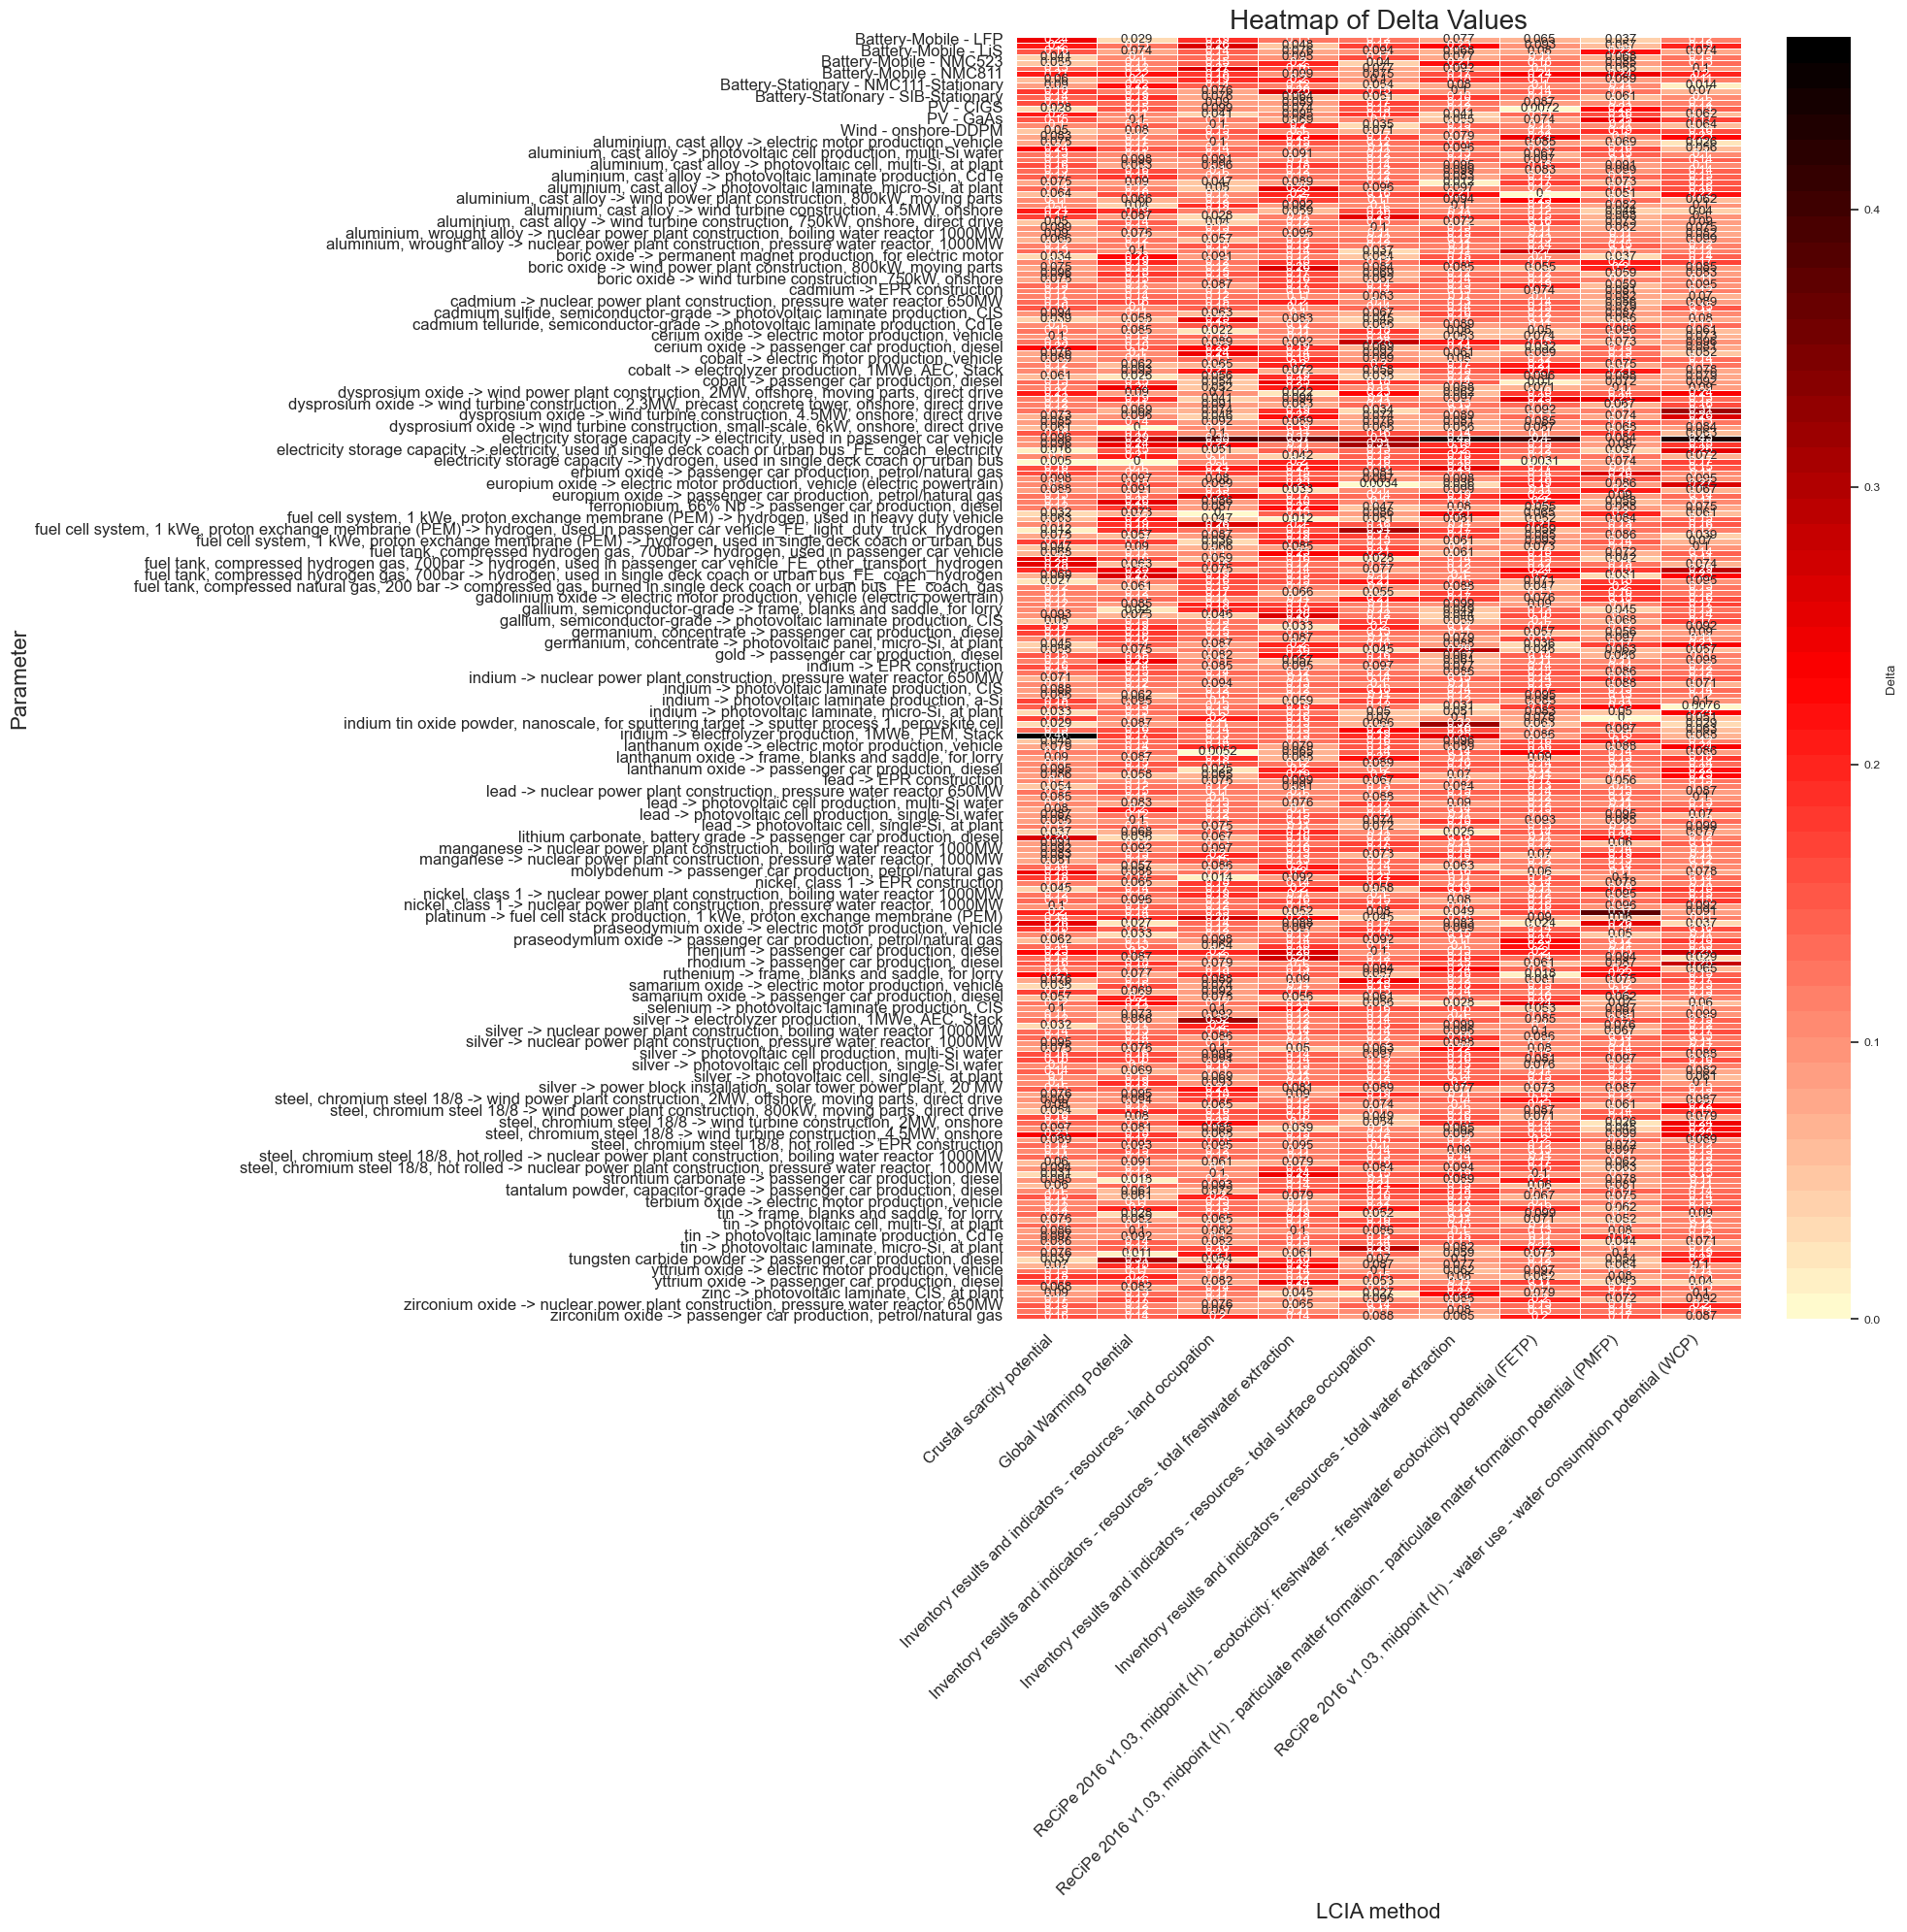

In [11]:
# Create a custom colormap that goes from white to yellow to red
colors = ['lemonchiffon', 'red','black']
n_bins = 50  # Number of bins for the colormap
cmap_name = 'white_yellow_red'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Plot the heatmap
plt.figure(figsize=(20, 20))  # Increase figure size
sns.set(font_scale=0.8)  # Adjust font scale
sns.heatmap(heatmap_data, annot=True, cmap=cm, cbar_kws={'label': 'Delta'}, linewidths=.5)
plt.title('Heatmap of Delta Values', fontsize=20)
plt.xlabel('LCIA method', fontsize=16)
plt.ylabel('Parameter', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

In [30]:
plt.show()

In [ ]:
plt.savefig('heatmap_normalized_delta.png')